# Full phase prediction

In this notebook we investigate the model perfomance when jointly predicting the full indicator vector of phase occurences. As usually we start with some global imports and fixation of a random seed for reproducibility of results.

In [1]:
import pandas as pd
import numpy as np

STATE = np.random.RandomState(seed=1000)

## Data and Models

Since we are concerned with modelling the full phase vector, our response matrix has three columns indicating presence of 'sphere', 'worm', and 'vesicle', respectively. We ignore other phases.

In [2]:
import data1 as data
x = data.x
y = data.y.filter(['sphere', 'worm', 'vesicle'], axis=1)
x.columns, y.columns

(Index(['clogp_corona', 'mon_corona_mw', 'mon_corona_apol', 'mon_corona_mv',
        'mon_corona_psa', 'dp_corona', 'corona_mw_total', 'corona_mv_total',
        'clogp_core', 'mon_core_mw', 'mon_core_apol', 'mon_core_mv',
        'mon_core_psa', 'dp_core', 'core_mw_total', 'core_mv_total',
        'ratio_mass', 'ratio_vol', 'conc', 'ph', 'salt', 'charged', 'temp',
        'core_BzMA', 'core_DAAM', 'core_EGEMA', 'core_GlyMA', 'core_HBMA',
        'core_HEMA', 'core_HPMA', 'core_MEMA', 'core_PhA', 'core_TFMA',
        'core_EGDMA', 'core_cyclic', 'corona_GMA', 'corona_MPC',
        'corona_AcETMAC', 'corona_MAA', 'corona_DMA', 'corona_PEG',
        'corona_CysMA', 'corona_GluMA', 'corona_DMAPS', 'corona_AEMA',
        'corona_QDMAEMA', 'corona_HPMAm', 'corona_KSPMA', 'corona_MAcEPyr',
        'corona_DSDMA', 'initiator_ACVA', 'initiator_AIBA',
        'initiator_KPS/AscAc', 'initiator_V-501', 'initiator_VA-044',
        'initiator_tBH-Na2SO3'],
       dtype='object'),
 Index(['sphere', 

For modelling, we focus on the best performing model for the indiviudal phases, the random forest model.

In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from gam import LogisticGAM

lr = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE)
lr_ind = BinaryRelevanceClassifier(lr)
lr_chain = ClassifierChain(lr, order=[0, 1, 2])
lr_pcc = ProbabilisticClassifierChain(lr) 

# gam_ind = BinaryRelevanceClassifier(LogisticGAM(lam=12.0, max_iter=250))
# gam_chain = ClassifierChain(LogisticGAM(lam=10.0, max_iter=250))
# gam_pcc = ProbabilisticClassifierChain(LogisticGAM(lam=10.0, max_iter=250))

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)
rf_ind = BinaryRelevanceClassifier(rf)
rf_chain = ClassifierChain(rf, order=[0, 2, 1])
rf_pcc = ProbabilisticClassifierChain(rf)

estimators = [lr_ind, lr_chain, lr_pcc, rf_ind, rf_chain, rf_pcc]
names = ['LR_ind', 'LR_chain', 'LR_pcc', 'RF_ind', 'RF_chain', 'RF_pcc']

## Interpolation performance

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from common import Experiment, LogLikelihoodEvaluator
from sklearn.model_selection import KFold

interpolation = Experiment(estimators, 
                    names,
                    KFold(20, shuffle=True, random_state=STATE),
                    x, y.replace(-1.0, 0.0),
                    groups=data.comp_ids.array, 
                    evaluators=['accuracy', LogLikelihoodEvaluator(2, neg=True)],
                    verbose=True).run()


Running experiment with 20 repetitions
********************


In [6]:
interpolation.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind,0.420705,0.005514,0.417419,0.075634,2.652914,0.009925,2.667420,0.187486
LR_chain,0.420705,0.005514,0.417419,0.075634,2.652914,0.009925,2.667420,0.187486
LR_pcc,0.420705,0.005514,0.417419,0.075634,2.652914,0.009925,2.667420,0.187486
RF_ind,0.998442,0.000533,0.789409,0.061032,0.243621,0.004309,1.132296,0.819949
RF_chain,0.998442,0.000533,0.805753,0.047142,0.234884,0.003652,1.178617,0.863384
RF_pcc,0.998182,0.000883,0.799247,0.053680,0.234022,0.004254,1.069175,0.820815


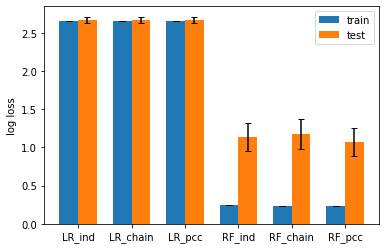

In [7]:
interpolation.plot_summary('log loss')

In [7]:
interpolation.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log likelihood,std_train_log likelihood,mean_test_log likelihood,std_test_log likelihood
LR_ind,0.421312,0.004340,0.419355,0.075979,-1.838934,0.005496,-1.845692,0.103435
LR_chain,0.421312,0.004340,0.419355,0.075979,-1.838934,0.005496,-1.845692,0.103435
LR_pcc,0.421312,0.004340,0.419355,0.075979,-1.838934,0.005496,-1.845692,0.103435
RF_ind,0.998355,0.000682,0.791237,0.060285,-0.168925,0.002539,-0.838891,0.578501
RF_chain,0.998442,0.000533,0.781398,0.070596,-0.161375,0.002280,-0.822889,0.571721
RF_pcc,0.997750,0.000988,0.786505,0.079395,-0.161944,0.002213,-0.849643,0.694967


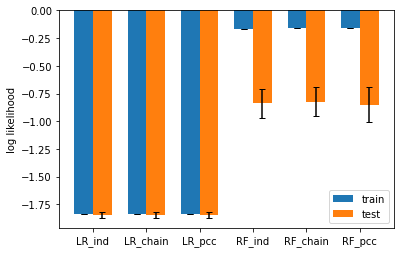

In [9]:
interpolation.plot_summary('log likelihood')

In [6]:
interpolation.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy
LR_ind,0.421312,0.004340,0.419355,0.075979
LR_chain,0.421312,0.004340,0.419355,0.075979
LR_pcc,0.421312,0.004340,0.419355,0.075979
RF_ind,0.998355,0.000682,0.791237,0.060285
RF_chain,0.998442,0.000533,0.781398,0.070596
RF_pcc,0.997750,0.000988,0.786505,0.079395


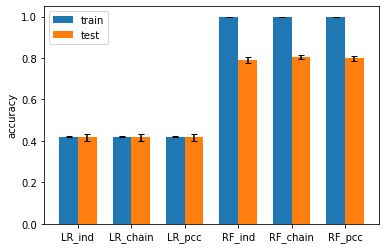

In [8]:
interpolation.plot_summary('accuracy')

## Extrapolation performance



In [9]:
from common import ExtrapolationExperiment, sample_size, GroupDescription
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score

extrapolation = ExtrapolationExperiment(estimators, 
                                        names,
                                        x, y.replace(-1, 0), data.comp_ids.values,
                                        score=['accuracy', LogLikelihoodEvaluator(2, neg=True), 
                                               sample_size,
                                               GroupDescription(data.comp_descr, 'composition')]).run()

Running experiment with 37 repetitions
*************************************


In [10]:
extrapolation.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss,mean_train_size,std_train_size,mean_test_size,std_test_size
LR_ind,0.420516,0.014522,0.434172,0.425249,2.651284,0.024313,2.479614,0.758042,591.567568,23.955445,16.432432,23.955445
LR_chain,0.420516,0.014522,0.434172,0.425249,2.651284,0.024313,2.479614,0.758042,591.567568,23.955445,16.432432,23.955445
LR_pcc,0.420516,0.014522,0.434172,0.425249,2.651284,0.024313,2.479614,0.758042,591.567568,23.955445,16.432432,23.955445
RF_ind,0.998082,0.000706,0.611153,0.425270,0.236545,0.005851,2.066950,2.411954,591.567568,23.955445,16.432432,23.955445
RF_chain,0.998082,0.000706,0.626657,0.401695,0.227314,0.005980,2.135549,2.508720,591.567568,23.955445,16.432432,23.955445
RF_pcc,0.996768,0.000987,0.650438,0.401983,0.227987,0.006033,1.883922,1.955158,591.567568,23.955445,16.432432,23.955445


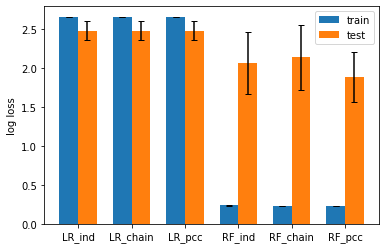

In [11]:
extrapolation.plot_summary('log loss')

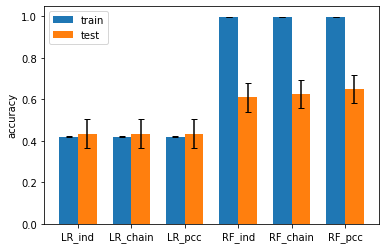

In [12]:
extrapolation.plot_summary('accuracy')

In [13]:
extrapolation.results_[extrapolation.results_.estimator=='RF_ind'].sort_values(['test_accuracy', 'test_size'], ascending=False)

,split,estimator,train_accuracy,test_accuracy,train_log loss,test_log loss,train_size,test_size,test_composition
45,7,RF_ind,0.998285,1.0,0.244161,1.033429,583,25,GMA/TFMA
69,11,RF_ind,0.996622,1.0,0.245213,0.54748,592,16,GMA/BzMA
93,15,RF_ind,0.998331,1.0,0.240698,0.715275,599,9,KSPMA/HPMA
99,16,RF_ind,0.998333,1.0,0.243188,0.136622,600,8,AEMA/HPMA
105,17,RF_ind,0.998336,1.0,0.242729,0.310692,601,7,AcETMAC/DAAM
123,20,RF_ind,0.998336,1.0,0.243005,1.22087,601,7,DMA/PhA
129,21,RF_ind,0.996678,1.0,0.238026,0.46179,602,6,MAcEPyr/EGEMA
135,22,RF_ind,0.998339,1.0,0.238902,0.958849,602,6,GMA/HBMA
159,26,RF_ind,0.99835,1.0,0.234696,0.074001,606,2,MPC/HPMA(0.985)+EGDMA(0.015)
165,27,RF_ind,0.99835,1.0,0.234838,0.074001,606,2,MPC/HPMA(0.988)+EGDMA(0.012)


In [14]:
extrapolation.results_[extrapolation.results_.estimator=='RF_pcc'].sort_values(['test_accuracy', 'test_size'], ascending=False)

,split,estimator,train_accuracy,test_accuracy,train_log loss,test_log loss,train_size,test_size,test_composition
47,7,RF_pcc,0.996569,1.0,0.23509,0.750315,583,25,GMA/TFMA
71,11,RF_pcc,0.996622,1.0,0.237471,0.404728,592,16,GMA/BzMA
95,15,RF_pcc,0.996661,1.0,0.227982,0.619013,599,9,KSPMA/HPMA
101,16,RF_pcc,0.996667,1.0,0.229333,0.119626,600,8,AEMA/HPMA
107,17,RF_pcc,0.996672,1.0,0.230383,0.306458,601,7,AcETMAC/DAAM
125,20,RF_pcc,0.996672,1.0,0.230766,1.217984,601,7,DMA/PhA
131,21,RF_pcc,0.996678,1.0,0.227492,0.478016,602,6,MAcEPyr/EGEMA
137,22,RF_pcc,0.998339,1.0,0.229254,0.72713,602,6,GMA/HBMA
161,26,RF_pcc,0.9967,1.0,0.225798,0.125045,606,2,MPC/HPMA(0.985)+EGDMA(0.015)
167,27,RF_pcc,0.9967,1.0,0.226267,0.110323,606,2,MPC/HPMA(0.988)+EGDMA(0.012)


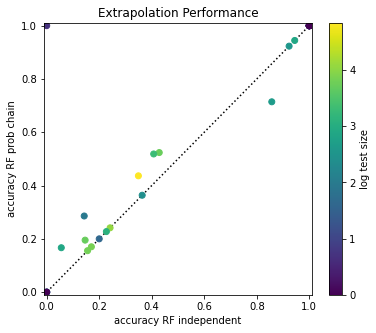

In [15]:
from matplotlib import pyplot as plt
from numpy import log

fig, ax = plt.subplots(figsize=(6, 5))
plt.plot([-0.05, 1.05], [-0.05, 1.05], linestyle=':', color='black', zorder=-1)
scatter = ax.scatter(
    extrapolation.results_[extrapolation.results_.estimator == 'RF_ind']['test_accuracy'], 
    extrapolation.results_[extrapolation.results_.estimator == 'RF_pcc']['test_accuracy'],
    marker='o', c=log(extrapolation.results_[extrapolation.results_.estimator == 'RF_ind']['test_size'].astype('int')))
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xlabel('accuracy RF independent')
plt.ylabel('accuracy RF prob chain')
plt.title('Extrapolation Performance')
plt.colorbar(scatter, label='log test size')
plt.show()